In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split

sns.set_style("dark")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os

In [2]:
train_df = pd.read_csv("train.csv",parse_dates=['date'])
test_df = pd.read_csv("test.csv",parse_dates=['date'])

In [3]:
train_df.tail(10)

,date,store,item,sales
912990,2017-12-22,10,50,75
912991,2017-12-23,10,50,70
912992,2017-12-24,10,50,76
912993,2017-12-25,10,50,51
912994,2017-12-26,10,50,41
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [4]:
train_df['train_or_test'] = 'train'
test_df['train_or_test'] = 'test'
test_df['sales'] = np.nan
df = pd.concat([train_df, test_df.loc[:, ['train_or_test','store', 'item', 'sales','date']]], ignore_index=True)
del train_df
del test_df
gc.collect()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


42

In [5]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['dayofmonth'] = df.date.dt.day
df['dayofweek'] = df.date.dt.dayofweek
df['dayofyear'] = df.date.dt.dayofyear
df['weekofyear'] = df.date.dt.weekofyear
df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
df['is_month_end'] = (df.date.dt.is_month_end).astype(int)
df['quarter'] = df.date.dt.quarter
df['week_block_num'] = [int(x) for x in np.floor((df.date - pd.to_datetime('2012-12-31')).dt.days/7) + 1]
df['quarter_block_num'] = (df['year'] - 2013) * 4 + df['quarter']

In [6]:
train_df = df[df.train_or_test=='train']
test_df = df[df.train_or_test=='test']
train_x = train_df.loc[:,[col for col in train_df.columns if col not in ['sales','train_or_test','date']]]
train_y = train_df['sales']
test_x = test_df.loc[:,[col for col in test_df.columns if col not in ['sales','train_or_test','date']]]

In [7]:
xgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'verbose': 0,
    'num_leaves': 512,
    'max_depth' : 8,
    'max_bin': 255,
    }

In [8]:
xgb_score4 = pd.DataFrame(columns=range(0,4))
count = 0

for state in range(25,46,20):
    x_train, x_valid, y_train, y_valid = train_test_split(train_x,train_y,test_size=0.25,random_state=state)

    xgb_dtrain = xgb.DMatrix(x_train, label=y_train)
    xgb_dvalid = xgb.DMatrix(x_valid, label=y_valid)

    evals_results = {}
    print("Training the xgb model...")
    watchlist = [(xgb_dtrain, 'train'),(xgb_dvalid, 'valid')]

    start = datetime.now()
    xgb_model = xgb.train(xgb_params, 
                     xgb_dtrain,
                     1500,
                     watchlist,
                     evals_result=evals_results, 
                     early_stopping_rounds=35,
                     verbose_eval=True)
    print("Total time taken : ", datetime.now()-start)
    xgb_x = xgb_model.predict(xgb.DMatrix(test_x),ntree_limit=xgb_model.best_iteration)
    xgb_score4.iloc[:,count] = pd.Series(xgb_x)
    count += 1

Training the xgb model...
[20:45:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[0]	train-rmse:58.205	valid-rmse:58.1922
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 35 rounds.
[20:45:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1]	train-rmse:57.2071	valid-rmse:57.1936
[20:45:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[2]	train-rmse:56.2325	valid-rmse:56.2182
[20:45:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[3]	train-rmse:55.2815	valid-rmse:55.2668
[20:45:48] C:\Users\Administrator\Desktop\xgboost\src\

[20:46:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[42]	train-rmse:30.8895	valid-rmse:30.8815
[20:46:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[43]	train-rmse:30.5123	valid-rmse:30.5055
[20:46:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[44]	train-rmse:30.1468	valid-rmse:30.141
[20:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[45]	train-rmse:29.7824	valid-rmse:29.7761
[20:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[46]	train-rmse:29.4356	valid-rmse:29.4304
[20:46:24] C:\Users\Admini

[20:46:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[85]	train-rmse:20.7072	valid-rmse:20.7148
[20:46:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[86]	train-rmse:20.583	valid-rmse:20.5909
[20:47:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[87]	train-rmse:20.4421	valid-rmse:20.4499
[20:47:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[88]	train-rmse:20.3193	valid-rmse:20.3276
[20:47:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[89]	train-rmse:20.1722	valid-rmse:20.1807
[20:47:03] C:\Users\Admini

[20:47:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[127]	train-rmse:16.5185	valid-rmse:16.5408
[20:47:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[128]	train-rmse:16.4441	valid-rmse:16.4667
[20:47:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[129]	train-rmse:16.2738	valid-rmse:16.2971
[20:47:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[130]	train-rmse:16.2128	valid-rmse:16.2367
[20:47:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[131]	train-rmse:16.1287	valid-rmse:16.1536
[20:47:42] C:\Users\

[20:48:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[169]	train-rmse:13.9354	valid-rmse:13.9723
[20:48:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[170]	train-rmse:13.8784	valid-rmse:13.9152
[20:48:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[171]	train-rmse:13.8258	valid-rmse:13.8632
[20:48:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[172]	train-rmse:13.7971	valid-rmse:13.8348
[20:48:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[173]	train-rmse:13.7541	valid-rmse:13.7919
[20:48:23] C:\Users\

[20:48:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[211]	train-rmse:12.3294	valid-rmse:12.3766
[20:48:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[212]	train-rmse:12.258	valid-rmse:12.3056
[20:49:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[213]	train-rmse:12.2325	valid-rmse:12.2806
[20:49:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[214]	train-rmse:12.2102	valid-rmse:12.2588
[20:49:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[215]	train-rmse:12.1808	valid-rmse:12.2295
[20:49:03] C:\Users\A

[20:49:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[253]	train-rmse:11.0788	valid-rmse:11.1363
[20:49:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[254]	train-rmse:11.0174	valid-rmse:11.075
[20:49:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[255]	train-rmse:10.9902	valid-rmse:11.0479
[20:49:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[256]	train-rmse:10.9687	valid-rmse:11.0266
[20:49:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[257]	train-rmse:10.9488	valid-rmse:11.007
[20:49:38] C:\Users\Ad

[20:50:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[295]	train-rmse:9.90697	valid-rmse:9.97399
[20:50:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[296]	train-rmse:9.89306	valid-rmse:9.96013
[20:50:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[297]	train-rmse:9.85556	valid-rmse:9.92279
[20:50:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[298]	train-rmse:9.8411	valid-rmse:9.90838
[20:50:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[299]	train-rmse:9.82575	valid-rmse:9.8934
[20:50:22] C:\Users\Ad

[20:50:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[337]	train-rmse:9.29566	valid-rmse:9.36999
[20:50:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[338]	train-rmse:9.26246	valid-rmse:9.33725
[20:50:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[339]	train-rmse:9.2518	valid-rmse:9.32686
[20:50:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[340]	train-rmse:9.24416	valid-rmse:9.31931
[20:51:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[341]	train-rmse:9.21293	valid-rmse:9.28837
[20:51:01] C:\Users\A

[20:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[379]	train-rmse:8.80767	valid-rmse:8.89064
[20:51:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[380]	train-rmse:8.8019	valid-rmse:8.88502
[20:51:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[381]	train-rmse:8.79311	valid-rmse:8.8763
[20:51:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[382]	train-rmse:8.78544	valid-rmse:8.86888
[20:51:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[383]	train-rmse:8.76708	valid-rmse:8.85113
[20:51:36] C:\Users\Ad

[20:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[421]	train-rmse:8.48237	valid-rmse:8.57373
[20:52:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[422]	train-rmse:8.47563	valid-rmse:8.56722
[20:52:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[423]	train-rmse:8.47114	valid-rmse:8.56295
[20:52:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[424]	train-rmse:8.4664	valid-rmse:8.55831
[20:52:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[425]	train-rmse:8.46135	valid-rmse:8.55332
[20:52:14] C:\Users\A

[20:52:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[463]	train-rmse:8.22243	valid-rmse:8.32188
[20:52:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[464]	train-rmse:8.214	valid-rmse:8.31375
[20:52:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[465]	train-rmse:8.20955	valid-rmse:8.30942
[20:52:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[466]	train-rmse:8.20695	valid-rmse:8.30696
[20:52:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[467]	train-rmse:8.20372	valid-rmse:8.30387
[20:52:49] C:\Users\Ad

[20:53:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[505]	train-rmse:7.98602	valid-rmse:8.09549
[20:53:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[506]	train-rmse:7.98199	valid-rmse:8.09164
[20:53:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[507]	train-rmse:7.97879	valid-rmse:8.08878
[20:53:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[508]	train-rmse:7.97608	valid-rmse:8.08633
[20:53:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[509]	train-rmse:7.97443	valid-rmse:8.08495
[20:53:26] C:\Users\

[20:53:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[547]	train-rmse:7.83429	valid-rmse:7.95272
[20:54:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[548]	train-rmse:7.83202	valid-rmse:7.95067
[20:54:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[549]	train-rmse:7.82857	valid-rmse:7.94734
[20:54:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[550]	train-rmse:7.82758	valid-rmse:7.94649
[20:54:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[551]	train-rmse:7.82198	valid-rmse:7.94107
[20:54:03] C:\Users\

[20:54:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[589]	train-rmse:7.71945	valid-rmse:7.84515
[20:54:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[590]	train-rmse:7.7156	valid-rmse:7.84134
[20:54:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[591]	train-rmse:7.71426	valid-rmse:7.84015
[20:54:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[592]	train-rmse:7.71313	valid-rmse:7.83914
[20:54:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[593]	train-rmse:7.71039	valid-rmse:7.83672
[20:54:40] C:\Users\A

[20:55:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[631]	train-rmse:7.61876	valid-rmse:7.75276
[20:55:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[632]	train-rmse:7.61362	valid-rmse:7.74787
[20:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[633]	train-rmse:7.61249	valid-rmse:7.74697
[20:55:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[634]	train-rmse:7.60921	valid-rmse:7.74395
[20:55:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[635]	train-rmse:7.6087	valid-rmse:7.74354
[20:55:17] C:\Users\A

[20:55:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[673]	train-rmse:7.54081	valid-rmse:7.68222
[20:55:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[674]	train-rmse:7.53967	valid-rmse:7.68123
[20:55:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[675]	train-rmse:7.53819	valid-rmse:7.67994
[20:55:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[676]	train-rmse:7.53773	valid-rmse:7.67957
[20:55:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[677]	train-rmse:7.53329	valid-rmse:7.67543
[20:55:54] C:\Users\

[20:56:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[715]	train-rmse:7.47885	valid-rmse:7.62751
[20:56:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[716]	train-rmse:7.47744	valid-rmse:7.6263
[20:56:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[717]	train-rmse:7.47647	valid-rmse:7.62549
[20:56:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[718]	train-rmse:7.47594	valid-rmse:7.62513
[20:56:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[719]	train-rmse:7.47545	valid-rmse:7.62476
[20:56:31] C:\Users\A

[20:57:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[757]	train-rmse:7.43175	valid-rmse:7.58678
[20:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[758]	train-rmse:7.42939	valid-rmse:7.58468
[20:57:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[759]	train-rmse:7.42753	valid-rmse:7.58293
[20:57:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[760]	train-rmse:7.42721	valid-rmse:7.58274
[20:57:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[761]	train-rmse:7.42648	valid-rmse:7.58218
[20:57:08] C:\Users\

[20:57:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[799]	train-rmse:7.38853	valid-rmse:7.55029
[20:57:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[800]	train-rmse:7.38823	valid-rmse:7.5501
[20:57:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[801]	train-rmse:7.38761	valid-rmse:7.54968
[20:57:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[802]	train-rmse:7.38705	valid-rmse:7.54929
[20:57:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[803]	train-rmse:7.38484	valid-rmse:7.54717
[20:57:46] C:\Users\A

[20:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[841]	train-rmse:7.34757	valid-rmse:7.51584
[20:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[842]	train-rmse:7.34571	valid-rmse:7.5142
[20:58:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[843]	train-rmse:7.34507	valid-rmse:7.51375
[20:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[844]	train-rmse:7.34438	valid-rmse:7.51323
[20:58:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=8
[845]	train-rmse:7.34413	valid-rmse:7.51309
[20:58:22] C:\Users\A

[20:58:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[883]	train-rmse:7.31466	valid-rmse:7.48965
[20:58:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[884]	train-rmse:7.31375	valid-rmse:7.4889
[20:58:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[885]	train-rmse:7.31287	valid-rmse:7.48822
[20:58:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[886]	train-rmse:7.31262	valid-rmse:7.48808
[20:58:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[887]	train-rmse:7.3114	valid-rmse:7.48707
[20:58:59] C:\Users\Ad

[20:59:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[925]	train-rmse:7.28548	valid-rmse:7.46707
[20:59:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[926]	train-rmse:7.2846	valid-rmse:7.46633
[20:59:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[927]	train-rmse:7.28405	valid-rmse:7.46601
[20:59:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[928]	train-rmse:7.28294	valid-rmse:7.4651
[20:59:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[929]	train-rmse:7.28212	valid-rmse:7.46438
[20:59:36] C:\Users\Ad

[21:00:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[967]	train-rmse:7.26438	valid-rmse:7.45159
[21:00:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[968]	train-rmse:7.26413	valid-rmse:7.45149
[21:00:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[969]	train-rmse:7.26368	valid-rmse:7.4511
[21:00:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[970]	train-rmse:7.26315	valid-rmse:7.45071
[21:00:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[971]	train-rmse:7.26278	valid-rmse:7.45053
[21:00:20] C:\Users\A

[21:01:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[1009]	train-rmse:7.24348	valid-rmse:7.43649
[21:01:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[1010]	train-rmse:7.2429	valid-rmse:7.43611
[21:01:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[1011]	train-rmse:7.24272	valid-rmse:7.43601
[21:01:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1012]	train-rmse:7.24175	valid-rmse:7.43522
[21:01:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1013]	train-rmse:7.24112	valid-rmse:7.43469
[21:01:04] C:\Us

[21:01:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1051]	train-rmse:7.22742	valid-rmse:7.42622
[21:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=8
[1052]	train-rmse:7.22727	valid-rmse:7.42613
[21:01:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[1053]	train-rmse:7.22711	valid-rmse:7.42605
[21:01:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1054]	train-rmse:7.2268	valid-rmse:7.42591
[21:01:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1055]	train-rmse:7.22664	valid-rmse:7.42584
[21:01:43] C:\Us

[21:02:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1093]	train-rmse:7.21161	valid-rmse:7.41618
[21:02:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1094]	train-rmse:7.2108	valid-rmse:7.41557
[21:02:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1095]	train-rmse:7.21056	valid-rmse:7.41551
[21:02:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1096]	train-rmse:7.21026	valid-rmse:7.41532
[21:02:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1097]	train-rmse:7.20993	valid-rmse:7.41519
[21:02:19] C:\Us

[21:02:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[1135]	train-rmse:7.19981	valid-rmse:7.40982
[21:02:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1136]	train-rmse:7.19962	valid-rmse:7.40979
[21:02:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[1137]	train-rmse:7.19934	valid-rmse:7.40962
[21:02:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1138]	train-rmse:7.1991	valid-rmse:7.40958
[21:02:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[1139]	train-rmse:7.19834	valid-rmse:7.40903
[21:02:57] C:\Us

[21:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1177]	train-rmse:7.18614	valid-rmse:7.40215
[21:03:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[1178]	train-rmse:7.18604	valid-rmse:7.40215
[21:03:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=8
[1179]	train-rmse:7.18591	valid-rmse:7.40212
[21:03:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=8
[1180]	train-rmse:7.18585	valid-rmse:7.40212
[21:03:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[1181]	train-rmse:7.18569	valid-rmse:7.40207
[21:03:35] C:\U

[21:04:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1219]	train-rmse:7.17596	valid-rmse:7.39715
[21:04:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[1220]	train-rmse:7.17589	valid-rmse:7.39714
[21:04:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[1221]	train-rmse:7.17578	valid-rmse:7.39714
[21:04:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[1222]	train-rmse:7.17568	valid-rmse:7.3971
[21:04:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1223]	train-rmse:7.17549	valid-rmse:7.39703
[21:04:13] C:\Us

[21:04:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[1261]	train-rmse:7.16795	valid-rmse:7.3938
[21:04:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1262]	train-rmse:7.16783	valid-rmse:7.39381
[21:04:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[1263]	train-rmse:7.16774	valid-rmse:7.39379
[21:04:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[1264]	train-rmse:7.16733	valid-rmse:7.39351
[21:04:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1265]	train-rmse:7.167	valid-rmse:7.39328
[21:04:52] C:\User

[21:05:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1303]	train-rmse:7.16006	valid-rmse:7.39076
[21:05:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[1304]	train-rmse:7.15992	valid-rmse:7.39073
[21:05:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[1305]	train-rmse:7.1596	valid-rmse:7.39057
[21:05:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[1306]	train-rmse:7.15935	valid-rmse:7.39046
[21:05:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[1307]	train-rmse:7.15929	valid-rmse:7.39045
[21:05:32] C:\Us

[21:06:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[1345]	train-rmse:7.15256	valid-rmse:7.38825
[21:06:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1346]	train-rmse:7.15214	valid-rmse:7.38798
[21:06:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[1347]	train-rmse:7.15198	valid-rmse:7.38797
[21:06:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[1348]	train-rmse:7.15179	valid-rmse:7.38794
[21:06:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1349]	train-rmse:7.15137	valid-rmse:7.38762
[21:06:15] C:\U

[21:06:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[1387]	train-rmse:7.14485	valid-rmse:7.38605
[21:06:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=8
[1388]	train-rmse:7.14477	valid-rmse:7.38604
[21:06:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[1389]	train-rmse:7.14436	valid-rmse:7.38581
[21:06:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[1390]	train-rmse:7.14427	valid-rmse:7.38582
[21:06:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[1391]	train-rmse:7.1442	valid-rmse:7.38582
[21:06:55] C:\Us

[21:07:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=8
[1429]	train-rmse:7.13945	valid-rmse:7.38506
[21:07:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[1430]	train-rmse:7.13931	valid-rmse:7.38503
[21:07:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[1431]	train-rmse:7.13924	valid-rmse:7.38502
[21:07:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=8
[1432]	train-rmse:7.13916	valid-rmse:7.38502
[21:07:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[1433]	train-rmse:7.1391	valid-rmse:7.38504
[21:07:33] C:\Us

[21:08:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[1471]	train-rmse:7.13301	valid-rmse:7.3831
[21:08:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[1472]	train-rmse:7.13266	valid-rmse:7.38295
[21:08:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[1473]	train-rmse:7.13245	valid-rmse:7.38294
[21:08:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1474]	train-rmse:7.13224	valid-rmse:7.38293
[21:08:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=8
[1475]	train-rmse:7.13216	valid-rmse:7.38295
[21:08:12] C:\Us

[21:08:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[12]	train-rmse:47.577	valid-rmse:47.6758
[21:08:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[13]	train-rmse:46.8189	valid-rmse:46.9167
[21:08:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[14]	train-rmse:46.0743	valid-rmse:46.1709
[21:08:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[15]	train-rmse:45.3507	valid-rmse:45.4461
[21:08:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[16]	train-rmse:44.6442	valid-rmse:44.7381
[21:08:57] C:\Users\Admini

[21:09:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[55]	train-rmse:26.6209	valid-rmse:26.7003
[21:09:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[56]	train-rmse:26.354	valid-rmse:26.4331
[21:09:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[57]	train-rmse:26.0877	valid-rmse:26.1673
[21:09:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[58]	train-rmse:25.8314	valid-rmse:25.911
[21:09:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[59]	train-rmse:25.5807	valid-rmse:25.6605
[21:09:35] C:\Users\Adminis

[21:10:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[98]	train-rmse:19.0576	valid-rmse:19.1433
[21:10:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[99]	train-rmse:18.9466	valid-rmse:19.0316
[21:10:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[100]	train-rmse:18.8576	valid-rmse:18.9433
[21:10:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[101]	train-rmse:18.7538	valid-rmse:18.8391
[21:10:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[102]	train-rmse:18.6472	valid-rmse:18.7325
[21:10:14] C:\Users\Ad

[21:10:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[140]	train-rmse:15.6966	valid-rmse:15.7916
[21:10:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[141]	train-rmse:15.5691	valid-rmse:15.6641
[21:10:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[142]	train-rmse:15.5075	valid-rmse:15.6022
[21:10:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[143]	train-rmse:15.4707	valid-rmse:15.5661
[21:10:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[144]	train-rmse:15.4034	valid-rmse:15.4994
[21:10:52] C:\Users\

[21:11:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[182]	train-rmse:13.5431	valid-rmse:13.6405
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[183]	train-rmse:13.4949	valid-rmse:13.5923
[21:11:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[184]	train-rmse:13.4618	valid-rmse:13.5592
[21:11:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[185]	train-rmse:13.4291	valid-rmse:13.5261
[21:11:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[186]	train-rmse:13.4038	valid-rmse:13.5012
[21:11:31] C:\Users\

[21:12:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[224]	train-rmse:11.9876	valid-rmse:12.0883
[21:12:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[225]	train-rmse:11.9567	valid-rmse:12.0573
[21:12:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[226]	train-rmse:11.9373	valid-rmse:12.0384
[21:12:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[227]	train-rmse:11.8814	valid-rmse:11.9828
[21:12:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[228]	train-rmse:11.8516	valid-rmse:11.9532
[21:12:09] C:\Users\

[21:12:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[266]	train-rmse:10.8236	valid-rmse:10.9302
[21:12:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[267]	train-rmse:10.7974	valid-rmse:10.9041
[21:12:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[268]	train-rmse:10.7844	valid-rmse:10.8917
[21:12:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[269]	train-rmse:10.7599	valid-rmse:10.8673
[21:12:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[270]	train-rmse:10.7357	valid-rmse:10.843
[21:12:45] C:\Users\A

[21:13:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[308]	train-rmse:9.85835	valid-rmse:9.96923
[21:13:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[309]	train-rmse:9.84585	valid-rmse:9.95704
[21:13:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[310]	train-rmse:9.8115	valid-rmse:9.92281
[21:13:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[311]	train-rmse:9.78128	valid-rmse:9.89283
[21:13:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[312]	train-rmse:9.76939	valid-rmse:9.8809
[21:13:21] C:\Users\Ad

[21:13:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[350]	train-rmse:9.15348	valid-rmse:9.26778
[21:13:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[351]	train-rmse:9.14836	valid-rmse:9.2628
[21:13:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[352]	train-rmse:9.1376	valid-rmse:9.2523
[21:13:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[353]	train-rmse:9.1245	valid-rmse:9.23929
[21:14:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[354]	train-rmse:9.11973	valid-rmse:9.23461
[21:14:01] C:\Users\Admi

[21:14:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[392]	train-rmse:8.68	valid-rmse:8.79798
[21:14:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[393]	train-rmse:8.67532	valid-rmse:8.79339
[21:14:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[394]	train-rmse:8.67145	valid-rmse:8.78957
[21:14:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[395]	train-rmse:8.65973	valid-rmse:8.77787
[21:14:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[396]	train-rmse:8.64944	valid-rmse:8.76764
[21:14:35] C:\Users\Adm

[21:15:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[434]	train-rmse:8.34767	valid-rmse:8.46968
[21:15:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[435]	train-rmse:8.34284	valid-rmse:8.46491
[21:15:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[436]	train-rmse:8.33945	valid-rmse:8.46153
[21:15:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[437]	train-rmse:8.33592	valid-rmse:8.45795
[21:15:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[438]	train-rmse:8.33108	valid-rmse:8.4532
[21:15:15] C:\Users\A

[21:15:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[476]	train-rmse:8.0883	valid-rmse:8.21406
[21:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[477]	train-rmse:8.08614	valid-rmse:8.21189
[21:15:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[478]	train-rmse:8.08292	valid-rmse:8.20889
[21:15:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[479]	train-rmse:8.08113	valid-rmse:8.20719
[21:15:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[480]	train-rmse:8.07838	valid-rmse:8.20448
[21:15:51] C:\Users\A

[21:16:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[518]	train-rmse:7.90763	valid-rmse:8.03843
[21:16:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[519]	train-rmse:7.89985	valid-rmse:8.0309
[21:16:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[520]	train-rmse:7.89724	valid-rmse:8.02847
[21:16:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[521]	train-rmse:7.89053	valid-rmse:8.02207
[21:16:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[522]	train-rmse:7.88929	valid-rmse:8.02095
[21:16:28] C:\Users\A

[21:17:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[560]	train-rmse:7.76229	valid-rmse:7.89836
[21:17:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[561]	train-rmse:7.75954	valid-rmse:7.89579
[21:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[562]	train-rmse:7.75544	valid-rmse:7.89194
[21:17:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[563]	train-rmse:7.75372	valid-rmse:7.89036
[21:17:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[564]	train-rmse:7.75078	valid-rmse:7.88761
[21:17:04] C:\Users\

[21:17:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[602]	train-rmse:7.65992	valid-rmse:7.80156
[21:17:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[603]	train-rmse:7.659	valid-rmse:7.80077
[21:17:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[604]	train-rmse:7.6575	valid-rmse:7.79936
[21:17:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=8
[605]	train-rmse:7.65686	valid-rmse:7.79883
[21:17:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[606]	train-rmse:7.65211	valid-rmse:7.7942
[21:17:41] C:\Users\Admi

[21:18:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=8
[644]	train-rmse:7.57915	valid-rmse:7.72617
[21:18:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[645]	train-rmse:7.57776	valid-rmse:7.72498
[21:18:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[646]	train-rmse:7.57571	valid-rmse:7.72313
[21:18:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[647]	train-rmse:7.5747	valid-rmse:7.72221
[21:18:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[648]	train-rmse:7.5727	valid-rmse:7.72038
[21:18:24] C:\Users\Ad

[21:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=8
[686]	train-rmse:7.51445	valid-rmse:7.66701
[21:19:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[687]	train-rmse:7.511	valid-rmse:7.66372
[21:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[688]	train-rmse:7.51025	valid-rmse:7.66308
[21:19:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[689]	train-rmse:7.50693	valid-rmse:7.65992
[21:19:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[690]	train-rmse:7.5059	valid-rmse:7.65903
[21:19:04] C:\Users\Adm

[21:19:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[728]	train-rmse:7.45614	valid-rmse:7.61428
[21:19:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[729]	train-rmse:7.45418	valid-rmse:7.61247
[21:19:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[730]	train-rmse:7.45321	valid-rmse:7.61164
[21:19:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=8
[731]	train-rmse:7.45282	valid-rmse:7.6113
[21:19:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[732]	train-rmse:7.45127	valid-rmse:7.60984
[21:19:42] C:\Users\A

[21:20:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[770]	train-rmse:7.40444	valid-rmse:7.56763
[21:20:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[771]	train-rmse:7.4029	valid-rmse:7.56622
[21:20:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[772]	train-rmse:7.40236	valid-rmse:7.56582
[21:20:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[773]	train-rmse:7.40133	valid-rmse:7.56495
[21:20:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[774]	train-rmse:7.40069	valid-rmse:7.56446
[21:20:22] C:\Users\A

[21:20:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[812]	train-rmse:7.36543	valid-rmse:7.53435
[21:20:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[813]	train-rmse:7.36484	valid-rmse:7.53387
[21:20:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[814]	train-rmse:7.36433	valid-rmse:7.53352
[21:20:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[815]	train-rmse:7.36299	valid-rmse:7.5323
[21:20:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[816]	train-rmse:7.36102	valid-rmse:7.5305
[21:20:58] C:\Users\Ad

[21:21:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[854]	train-rmse:7.32553	valid-rmse:7.50012
[21:21:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[855]	train-rmse:7.32447	valid-rmse:7.4992
[21:21:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[856]	train-rmse:7.32402	valid-rmse:7.49891
[21:21:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[857]	train-rmse:7.32333	valid-rmse:7.49833
[21:21:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[858]	train-rmse:7.32293	valid-rmse:7.49811
[21:21:36] C:\Users\A

[21:22:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[896]	train-rmse:7.29814	valid-rmse:7.47865
[21:22:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[897]	train-rmse:7.29721	valid-rmse:7.47782
[21:22:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[898]	train-rmse:7.2968	valid-rmse:7.47756
[21:22:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[899]	train-rmse:7.29567	valid-rmse:7.47657
[21:22:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[900]	train-rmse:7.29462	valid-rmse:7.47564
[21:22:20] C:\Users\A

[21:22:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[938]	train-rmse:7.27442	valid-rmse:7.46074
[21:22:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[939]	train-rmse:7.27367	valid-rmse:7.46015
[21:22:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[940]	train-rmse:7.27313	valid-rmse:7.45968
[21:22:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[941]	train-rmse:7.27243	valid-rmse:7.45911
[21:22:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[942]	train-rmse:7.27218	valid-rmse:7.45894
[21:22:59] C:\Users\

[21:23:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[980]	train-rmse:7.25414	valid-rmse:7.44568
[21:23:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[981]	train-rmse:7.2534	valid-rmse:7.44508
[21:23:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[982]	train-rmse:7.25313	valid-rmse:7.44495
[21:23:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=8
[983]	train-rmse:7.25295	valid-rmse:7.44487
[21:23:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[984]	train-rmse:7.2527	valid-rmse:7.44477
[21:23:42] C:\Users\Ad

[21:24:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1022]	train-rmse:7.23795	valid-rmse:7.43466
[21:24:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[1023]	train-rmse:7.23761	valid-rmse:7.43442
[21:24:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[1024]	train-rmse:7.23706	valid-rmse:7.43401
[21:24:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1025]	train-rmse:7.23677	valid-rmse:7.43391
[21:24:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1026]	train-rmse:7.23631	valid-rmse:7.43358
[21:24:22] C:\U

[21:24:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1064]	train-rmse:7.22112	valid-rmse:7.4232
[21:24:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[1065]	train-rmse:7.22065	valid-rmse:7.42287
[21:24:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1066]	train-rmse:7.22006	valid-rmse:7.42239
[21:25:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1067]	train-rmse:7.21978	valid-rmse:7.42225
[21:25:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1068]	train-rmse:7.21954	valid-rmse:7.42217
[21:25:02] C:\Us

[21:25:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=8
[1106]	train-rmse:7.20998	valid-rmse:7.41659
[21:25:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=8
[1107]	train-rmse:7.20978	valid-rmse:7.41652
[21:25:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[1108]	train-rmse:7.20932	valid-rmse:7.41621
[21:25:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=8
[1109]	train-rmse:7.20927	valid-rmse:7.41621
[21:25:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[1110]	train-rmse:7.20917	valid-rmse:7.41617
[21:25:40] C:\U

[21:26:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=8
[1148]	train-rmse:7.19979	valid-rmse:7.41096
[21:26:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1149]	train-rmse:7.19947	valid-rmse:7.41078
[21:26:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[1150]	train-rmse:7.1994	valid-rmse:7.41076
[21:26:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1151]	train-rmse:7.19876	valid-rmse:7.41025
[21:26:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[1152]	train-rmse:7.19865	valid-rmse:7.41025
[21:26:13] C:\Us

[21:26:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1190]	train-rmse:7.1874	valid-rmse:7.40329
[21:26:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1191]	train-rmse:7.18717	valid-rmse:7.40323
[21:26:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[1192]	train-rmse:7.18653	valid-rmse:7.40274
[21:26:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=8
[1193]	train-rmse:7.18646	valid-rmse:7.40274
[21:26:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1194]	train-rmse:7.18624	valid-rmse:7.40266
[21:26:44] C:\Us

[21:27:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=8
[1232]	train-rmse:7.17927	valid-rmse:7.39968
[21:27:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=8
[1233]	train-rmse:7.17917	valid-rmse:7.39963
[21:27:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[1234]	train-rmse:7.17896	valid-rmse:7.39951
[21:27:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1235]	train-rmse:7.1787	valid-rmse:7.39941
[21:27:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1236]	train-rmse:7.17847	valid-rmse:7.39931
[21:27:15] C:\Us

[21:27:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[1274]	train-rmse:7.16898	valid-rmse:7.39391
[21:27:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[1275]	train-rmse:7.16888	valid-rmse:7.39385
[21:27:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1276]	train-rmse:7.16836	valid-rmse:7.39349
[21:27:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=8
[1277]	train-rmse:7.16787	valid-rmse:7.39313
[21:27:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=8
[1278]	train-rmse:7.16774	valid-rmse:7.39309
[21:27:49] C:\U

[21:28:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1316]	train-rmse:7.15984	valid-rmse:7.38924
[21:28:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[1317]	train-rmse:7.15971	valid-rmse:7.3892
[21:28:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[1318]	train-rmse:7.15962	valid-rmse:7.38919
[21:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=8
[1319]	train-rmse:7.15951	valid-rmse:7.38916
[21:28:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=8
[1320]	train-rmse:7.15938	valid-rmse:7.38912
[21:28:22] C:\Us

[21:28:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1358]	train-rmse:7.1525	valid-rmse:7.38682
[21:28:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1359]	train-rmse:7.15236	valid-rmse:7.38683
[21:28:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=8
[1360]	train-rmse:7.15217	valid-rmse:7.38678
[21:28:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[1361]	train-rmse:7.15203	valid-rmse:7.38677
[21:28:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=8
[1362]	train-rmse:7.15195	valid-rmse:7.38673
[21:28:55] C:\Us

[21:29:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=8
[1400]	train-rmse:7.14403	valid-rmse:7.38358
[21:29:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=8
[1401]	train-rmse:7.14381	valid-rmse:7.38351
[21:29:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[1402]	train-rmse:7.14368	valid-rmse:7.38349
[21:29:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=8
[1403]	train-rmse:7.14357	valid-rmse:7.38348
[21:29:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[1404]	train-rmse:7.14354	valid-rmse:7.38348
[21:29:27] C:\U

[21:29:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=8
[1442]	train-rmse:7.13836	valid-rmse:7.38222
[21:29:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=8
[1443]	train-rmse:7.13821	valid-rmse:7.38221
[21:29:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=8
[1444]	train-rmse:7.13814	valid-rmse:7.3822
[21:29:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=8
[1445]	train-rmse:7.13795	valid-rmse:7.38209
[21:29:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=8
[1446]	train-rmse:7.13781	valid-rmse:7.3821
[21:29:57] C:\Use

[21:30:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=8
[1484]	train-rmse:7.13138	valid-rmse:7.38004
[21:30:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=8
[1485]	train-rmse:7.13127	valid-rmse:7.38
[21:30:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=8
[1486]	train-rmse:7.13112	valid-rmse:7.37997
[21:30:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[1487]	train-rmse:7.13103	valid-rmse:7.37998
[21:30:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=8
[1488]	train-rmse:7.13093	valid-rmse:7.37996
[21:30:31] C:\User

In [9]:
xgb_x = pd.DataFrame(xgb_x)
sum = xgb_score4.sum(axis=1)/2
answer = xgb_x.reset_index()
answer.rename(columns={'index' : 'id',0 : 'sales'},inplace=True)
answer['sales'] = sum

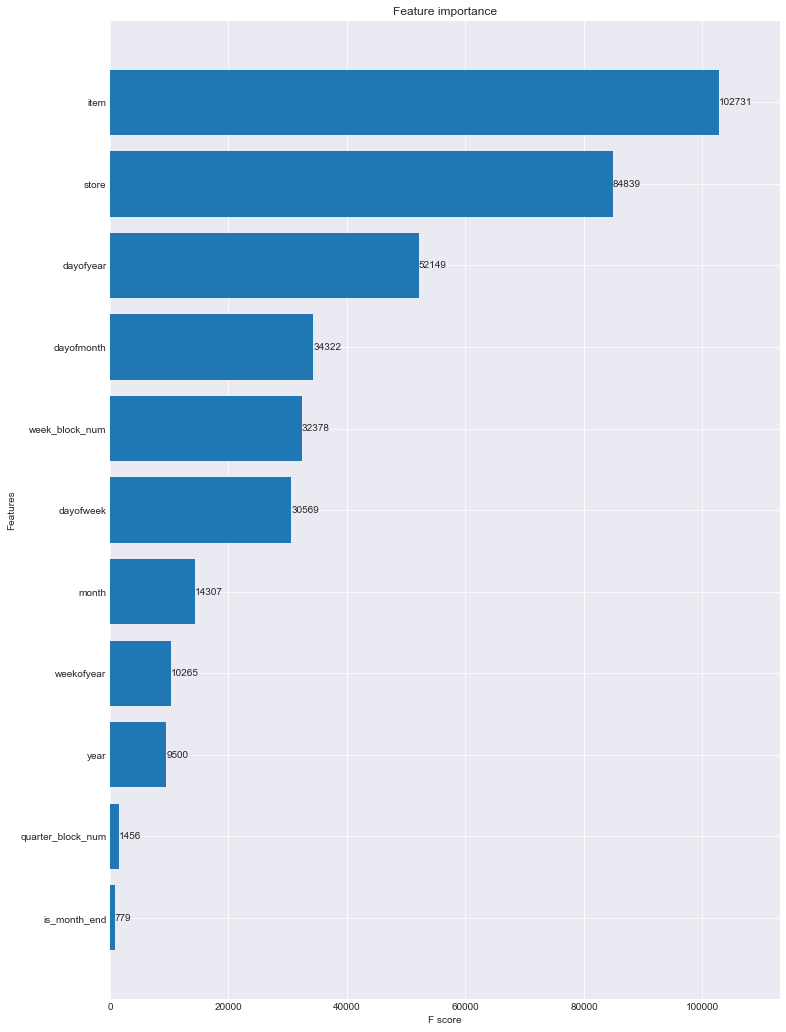

In [10]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [11]:
answer.to_csv('submission_xgb.csv',index=False)